<a href="https://colab.research.google.com/github/Ana1890/MRIimages_deeplearning/blob/main/3_early_stopping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Estadificación de Alzheimer por medio de imágenes MRI utilizando redes neuronales

Dataset provisto por el sitio web de Kaggle: https://www.kaggle.com/tourist55/Alzheimers-dataset-4-class-of-images

Probamos el modelo sin un pre-procesamiento demasiado fino


In [1]:
!pip install progress

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for progress: filename=progress-1.6-py3-none-any.whl size=9632 sha256=5589fb73d9d8664a92a0f227c22dacd262df3067a1446dceabc9ea12f1a56599
  Stored in directory: /root/.cache/pip/wheels/8e/d7/61/498d8e27dc11e9805b01eb3539e2ee344436fc226daeb5fe87
Successfully built progress


Accedemos a nuestro drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
os.chdir('/content/drive/MyDrive/MRI detection Alzheimer/db/Alzheimer_s Dataset')

In [4]:
!ls

data  test  train


In [5]:
!ls test

MildDemented  ModerateDemented	NonDemented  VeryMildDemented


In [6]:
!ls train

MildDemented  ModerateDemented	NonDemented  VeryMildDemented


# Importamos librerías necesarias

In [7]:
# Generales
import os
import matplotlib.pyplot as plt
import cv2
import numpy as np
import random

# Data
from sklearn.model_selection import train_test_split

from torch.utils.data import Dataset

# Model
import torch
import torch.nn as nn
from torchvision import datasets, models, transforms
# from pytorchtools import EarlyStopping

# Métricas y visualización
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import f1_score

# Config

In [8]:
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

# Cargar datos

In [9]:
FOLDER_PATH = 'train'
categories = sorted(os.listdir(FOLDER_PATH))
num_classes = 4

MILD_INDEX = categories.index("MildDemented")
MODERATE_INDEX = categories.index("ModerateDemented")
NON_INDEX = categories.index("NonDemented")
VERYMILD_INDEX = categories.index("VeryMildDemented")

# Almacenar las rutas a las imagenes agrupados por categorias en memoria
images_path = [list() for category in categories]

for index, category in enumerate(categories):
    category_path = os.path.join(FOLDER_PATH, category)

    # Recorrer imágenes
    images = [i for i in os.listdir(category_path)]
    for image_name in images:
        image_path = os.path.join(category_path, image_name)
        images_path[index].append(image_path)

print("Sobre el dataset")
for category_name, images in zip(categories, images_path):
    print("#Imagenes de la clase {}: {}".format(category_name, len(images)))

Sobre el dataset
#Imagenes de la clase MildDemented: 717
#Imagenes de la clase ModerateDemented: 52
#Imagenes de la clase NonDemented: 2560
#Imagenes de la clase VeryMildDemented: 1792


In [10]:
train_data = list()

for class_index, images_per_class in enumerate(images_path):
  train_data.extend([(img, class_index) for img in images_per_class])

In [11]:
FOLDER_PATH_TEST = 'test'
categories_test = sorted(os.listdir(FOLDER_PATH_TEST))
num_classes = 4

MILD_INDEX_TEST = categories_test.index("MildDemented")
MODERATE_INDEX_TEST = categories_test.index("ModerateDemented")
NON_INDEX_TEST = categories_test.index("NonDemented")
VERYMILD_INDEX_TEST = categories_test.index("VeryMildDemented")

# Almacenar las rutas a las imagenes agrupados por categorias en memoria
images_path_test = [list() for category in categories_test]

for index, category in enumerate(categories_test):
    category_path_test = os.path.join(FOLDER_PATH_TEST, category)

    # Recorrer imágenes
    images_test = [i for i in os.listdir(category_path_test)]
    for image_name in images_test:
        image_path_test = os.path.join(category_path_test, image_name)
        images_path_test[index].append(image_path_test)

print("Sobre el dataset")
for category_name, images in zip(categories_test, images_path_test):
    print("#Imagenes de la clase {}: {}".format(category_name, len(images)))

Sobre el dataset
#Imagenes de la clase MildDemented: 179
#Imagenes de la clase ModerateDemented: 12
#Imagenes de la clase NonDemented: 640
#Imagenes de la clase VeryMildDemented: 448


In [12]:
test_data = list()

for class_index, images_per_class in enumerate(images_path_test):
  test_data.extend([(img, class_index) for img in images_per_class])

* Las clases están muy desbalanceadas

## Visualización random

In [13]:
# random.seed(0)

def pick_randomly_file(image_list, ammount):
    max_length = len(image_list)
    chosen_images = []
    for _ in range(ammount):
        index = random.randint(0, max_length)
        chosen_images.append(image_list[index])
    
    return chosen_images


sample_images = 5
mild_sample = pick_randomly_file(images_path[MILD_INDEX], sample_images)
moderate_sample = pick_randomly_file(images_path[MODERATE_INDEX], sample_images)
non_sample = pick_randomly_file(images_path[NON_INDEX], sample_images)
Verymild_sample = pick_randomly_file(images_path[VERYMILD_INDEX], sample_images)


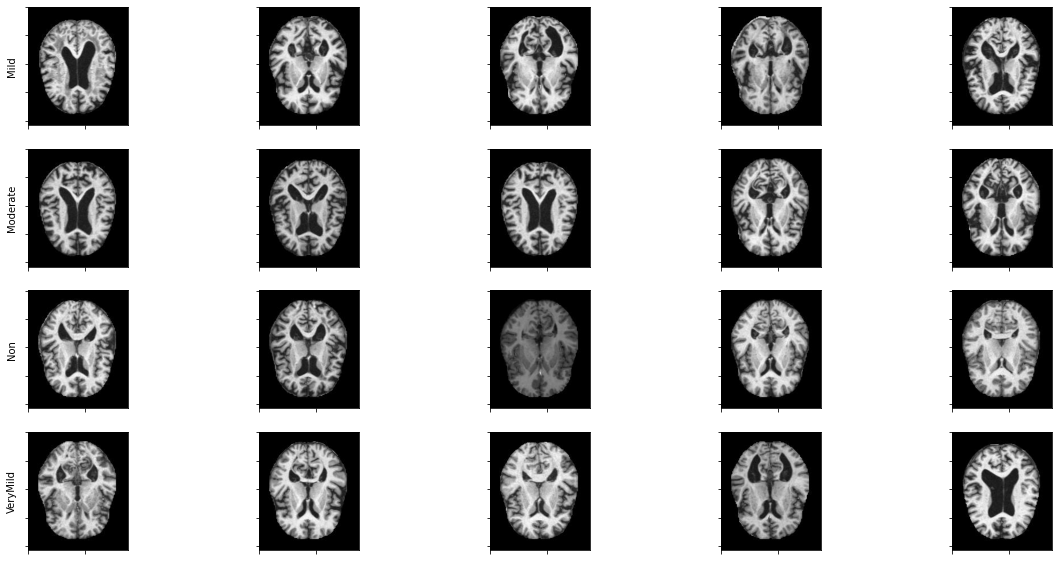

In [14]:
def visualize_sample(image_list, ax, title):
    ax[0].set_ylabel(title)
    for index in range(len(image_list)):        
        ax[index].imshow(cv2.imread(image_list[index]))
        ax[index].set_yticklabels([])
        ax[index].set_xticklabels([])


fx, ax = plt.subplots(num_classes,sample_images, figsize=(20,10))
visualize_sample(mild_sample, ax[0], "Mild")
visualize_sample(moderate_sample, ax[1], "Moderate")
visualize_sample(non_sample, ax[2], "Non")
visualize_sample(Verymild_sample, ax[3], "VeryMild")

plt.show()

In [15]:
img_sample = cv2.imread(train_data[0][0])

In [16]:
img_sample.shape

(208, 176, 3)

El conjunto de datos se encuentra desbalanceado, tiene imágenes de una dimensión de 208 x 176 x 3 dimensiones. 

# Train, Test y Validation datasets

In [17]:
full_data = train_data.extend(test_data)

In [18]:
len(train_data)

6400

In [19]:
data_array = np.array(train_data)

In [20]:
data_train, data_test, label_train, label_test = train_test_split(data_array[:,0], data_array[:,1], test_size=0.20, shuffle=True, random_state=SEED)
data_train, data_val, label_train, label_val = train_test_split(data_train, label_train, test_size=0.20, shuffle = True, random_state=SEED)

In [21]:
train_data = list()
for el in zip(data_train,label_train):
  train_data.append(el)

val_data = list()
for el in zip(data_val, label_val):
  val_data.append(el)

test_data = list()
for el in zip(data_test, label_test):
  test_data.append(el)

In [22]:
len(train_data), len(val_data), len(test_data)

(4096, 1024, 1280)

In [23]:
np.unique(np.array(train_data)[:,1], return_counts=True)

(array(['0', '1', '2', '3'], dtype='<U42'), array([ 554,   40, 2050, 1452]))

In [24]:
np.unique(np.array(val_data)[:,1], return_counts=True)

(array(['0', '1', '2', '3'], dtype='<U42'), array([141,  11, 507, 365]))

In [25]:
np.unique(np.array(test_data)[:,1], return_counts=True)

(array(['0', '1', '2', '3'], dtype='<U42'), array([201,  13, 643, 423]))

In [26]:
train_data[0]

('train/MildDemented/mildDem327.jpg', '0')

# Clase DataSet

Pre-procesamiento planteado: 
* Reshape
* Normalzación
* Mejoras a futuro: data augmentation para las clases minoritarias "Mild demented", "Moderate demented"

In [27]:
from torch.utils.data import Dataset

class Get_Dataset(Dataset):
  """
  Procesa todas las imágenes de interés para el entrenamiento y los devuelve de a batches con un dataloader
  """

  def __init__(self, raw_data, input_size=(224,224)):
        self.raw_data = raw_data
        self.input_size = input_size


  def __len__(self):
      return len(self.raw_data)

  def __getitem__(self, idx):
      label = self.raw_data[idx][1].astype('int')
      #print(label)
      target_tensor = torch.tensor(label).type(torch.LongTensor)
      
      img_path = self.raw_data[idx][0]
      image = cv2.imread(img_path)
      image = cv2.resize(image, self.input_size)
      image = image / 255.

      input_tensor = torch.from_numpy(image).reshape(3,self.input_size[0], self.input_size[1]).float()
      # print(input_tensor.dtype)

      return input_tensor, target_tensor

# Creamos la red neuronal

In [28]:
import torch
import torch.nn as nn
from torchvision import datasets, models, transforms

In [132]:
model = models.resnet50(pretrained=True)
backbone_out = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(backbone_out,256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256,4),
    nn.LogSoftmax(dim=1)
)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# Definimos algunos hiperparámetros

In [133]:
# Hyperparameters
# lr = 0.0001              # Learning rate
lr = 0.0001
input_size = (224,224)

# Select the device to use
if torch.cuda.is_available(): device = torch.device('cuda')
else: device = torch.device('cpu')

# Send the model to the device
model = model.to(device)

# Create dataloader
from torch.utils.data import DataLoader

batch_size = 50

In [134]:
from torchsummary import summary

summary(model, (3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [135]:
dataset = Get_Dataset(train_data)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

dataset_val = Get_Dataset(val_data)
dataloader_val = DataLoader(dataset_val, batch_size=batch_size, shuffle=False)

In [136]:
import torch.optim as optim


# Optimizador
optimizer = optim.Adam(model.parameters(), lr=lr)

n_samples = len(train_data)
n_classes = len(categories)

w1 = (n_samples/(n_classes*554)) 
w2 =(( n_samples/(n_classes*40)) * 0.10 )
w3 = n_samples/(n_classes*2050) 
w4 = n_samples/(n_classes*1452) 

weight = torch.tensor([w1,w2,w3,w4])

weight = weight.to(device)

# Función de pérdida
criterion = nn.NLLLoss(weight= weight)

In [137]:
patience = 3

# Entrenamiento

In [138]:
import sys
from progress.bar import Bar

def train_model(model, train_data, val_data, criterion, patience, optimizer, num_epochs=25):

    # pérdidas por item
    train_losses = []
    # pérdidas por item
    valid_losses = []
    # péridas por épocas
    avg_train_losses = []
    # pérdidas por épocas
    avg_valid_losses = [] 
    
    # Inicializo variables para el early stopping
    last_loss = 100
    triggertimes = 0

    
    Bar.check_tty = False
    Bar.file = sys.stdout

    for epoch in range(num_epochs):

        total_loss = 0.0
        processed = 0
        bar = Bar('Training Model', max=len(dataloader))

        # Entrenamiento
        model.train()
        for index, (X,y) in enumerate(dataloader):
            input_tensor = X
            gt_tensor = y

            input_tensor = input_tensor.to(device)
            gt_tensor = gt_tensor.to(device)

            optimizer.zero_grad()
            output = model(input_tensor)
            loss = criterion(output, gt_tensor)
            total_loss += loss.item()

            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())

            processed += input_tensor.shape[0]
            Bar.suffix = 'Train: [{0}][{1}/{2}]|Tot: {total:} |ETA: {eta:} '.format(epoch+1, processed, len(train_data),total=bar.elapsed_td, eta=bar.eta_td)
            Bar.suffix = Bar.suffix + '| Loss {:.4f} '.format(total_loss / (index + 1))
            bar.next()

            
        bar.finish()

        # Validación
        total_loss = 0.0
        processed = 0
        bar = Bar('Evaluating Model', max=len(dataloader_val))
        model.eval() 
        for index, (X,y) in enumerate(dataloader_val):
            input_tensor = X
            gt_tensor = y

            input_tensor = input_tensor.to(device)
            gt_tensor = gt_tensor.to(device)
            # forward pass
            output = model(input_tensor)
            loss = criterion(output, gt_tensor)
            total_loss += loss.item()
            
            valid_losses.append(loss.item())

            processed += input_tensor.shape[0]
            Bar.suffix = 'Val: [{0}][{1}/{2}]|Tot: {total:} |ETA: {eta:} '.format(epoch+1, processed, len(val_data),total=bar.elapsed_td, eta=bar.eta_td)
            Bar.suffix = Bar.suffix + '| Loss {:.4f} '.format(total_loss / (index + 1))
            bar.next()
        bar.finish()

        # Cálculo de las pérdidas por épocas
        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)

        
        print_msg = (f'train_loss: {train_loss:.5f} ' +
                     f'valid_loss: {valid_loss:.5f}')
        

        print(print_msg)
        
        if valid_loss > last_loss:
            trigger_times += 1
            print('Trigger Times:', trigger_times)

            if trigger_times >= patience:
                print('Early stopping!\nStart to test process.')
                return model, avg_train_losses, avg_valid_losses

        else:
            print('trigger times: 0')
            trigger_times = 0

        last_loss = valid_loss

        # limipiar listas para la próxima época
        train_losses = []
        valid_losses = []

        
    return model, avg_train_losses, avg_valid_losses

In [139]:
model, train_loss, valid_loss = train_model(model, train_data, val_data, criterion, patience, optimizer, num_epochs = 8)

Training Model |################################| Train: [1][4096/4096]|Tot: 0:00:52 |ETA: 0:00:01 | Loss 0.9808 
Evaluating Model |################################| Val: [1][1024/1024]|Tot: 0:00:05 |ETA: 0:00:01 | Loss 0.6675 
train_loss: 0.98078 valid_loss: 0.66753
trigger times: 0
Training Model |################################| Train: [2][4096/4096]|Tot: 0:00:53 |ETA: 0:00:01 | Loss 0.3821 
Evaluating Model |################################| Val: [2][1024/1024]|Tot: 0:00:05 |ETA: 0:00:01 | Loss 0.4382 
train_loss: 0.38206 valid_loss: 0.43817
trigger times: 0
Training Model |################################| Train: [3][4096/4096]|Tot: 0:00:53 |ETA: 0:00:01 | Loss 0.1327 
Evaluating Model |################################| Val: [3][1024/1024]|Tot: 0:00:05 |ETA: 0:00:01 | Loss 0.4500 
train_loss: 0.13274 valid_loss: 0.44997
Trigger Times: 1
Training Model |################################| Train: [4][4096/4096]|Tot: 0:00:53 |ETA: 0:00:01 | Loss 0.0695 
Evaluating Model |#############

# Curvas de pérdida

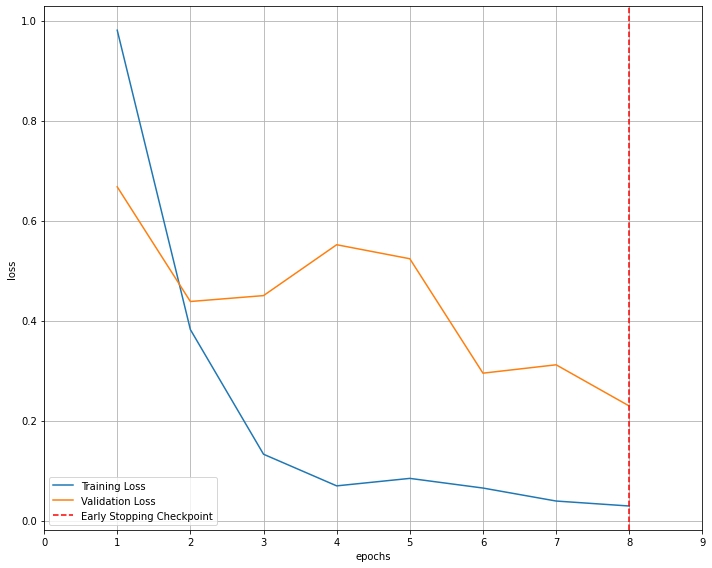

In [140]:
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(train_loss)+1),train_loss, label='Training Loss')
plt.plot(range(1,len(valid_loss)+1),valid_loss,label='Validation Loss')

# Posición del menor valor de validation loss
minposs = valid_loss.index(min(valid_loss))+1 
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('loss')

plt.xlim(0, len(train_loss)+1) 
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig('loss_plot.png', bbox_inches='tight')

La curva de loss validation no está decreciendo de forma continua, lo que puede indicar que estamos en presencia de pocos datos

# Pre procesamos datos nuevos

In [141]:
def preprocess(path_to_image, label):
    img = cv2.imread(path_to_image)
    img = cv2.resize(img, input_size)    
    img = img / 255.
    input_tensor = torch.from_numpy(img).reshape(1, 3, input_size[0],input_size[1]).float()

    label = label.astype('int')
    gt_tensor = torch.tensor(label).type(torch.LongTensor).reshape(1)
    #print(gt_tensor.shape)
    return input_tensor, gt_tensor

In [142]:
def test_model(model, test_data):

    y_true = []
    y_pred = []
    model = model.eval()
    Bar.check_tty = False
    Bar.file = sys.stdout
    bar = Bar('Testing Model', max=len(test_data))

    stats = [0 for _ in categories]
    total_items = [0 for _ in categories]
    for index, input_data in enumerate(test_data):
        img_path, target_class = input_data
        input_tensor, _ = preprocess(img_path, target_class)
        #print(_.shape)
        input_tensor = input_tensor.to(device)
        _ = _.to(device)

        output = model(input_tensor)
        #print(output.shape)
        loss = criterion(output, _)

        prediction = torch.argmax(output).item()
        
        target_class = target_class.astype('int')

        y_pred.append(prediction)
        y_true.append(target_class)
        #print(target_class)

        
        if target_class == prediction:
            stats[target_class] += 1
        total_items[target_class] += 1
        Bar.suffix = 'Test: [{0}/{1}]|Tot: {total:} |ETA: {eta:} '.format(index, len(test_data),total=bar.elapsed_td, eta=bar.eta_td)
        bar.next()
    
    bar.finish()
    for category_name, stat, tot in zip(categories, stats, total_items):
        acc = stat * 1.0 / tot
        print("Accuracy for class {}: {:.4f}".format(category_name, acc))
    

    # Reporte de clasificación y confusion matrix
    print("\nReporte de clasificación: \n", classification_report(y_true, y_pred, target_names = categories))
    print("\nMatriz de confusión: \n")

    conf_arr = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

    ax = sns.heatmap(conf_arr, cmap='Greens', annot=True, fmt='d', xticklabels = categories, yticklabels = categories)

    plt.title('Alzheimer\'s Disease Diagnosis')
    plt.xlabel('Prediction')
    plt.ylabel('Truth')
    plt.show(ax)

Testing Model |################################| Test: [1279/1280]|Tot: 0:00:21 |ETA: 0:00:01 
Accuracy for class MildDemented: 0.9403
Accuracy for class ModerateDemented: 0.9231
Accuracy for class NonDemented: 0.9285
Accuracy for class VeryMildDemented: 0.9338

Reporte de clasificación: 
                   precision    recall  f1-score   support

    MildDemented       0.94      0.94      0.94       201
ModerateDemented       0.92      0.92      0.92        13
     NonDemented       0.96      0.93      0.94       643
VeryMildDemented       0.89      0.93      0.91       423

        accuracy                           0.93      1280
       macro avg       0.93      0.93      0.93      1280
    weighted avg       0.93      0.93      0.93      1280


Matriz de confusión: 



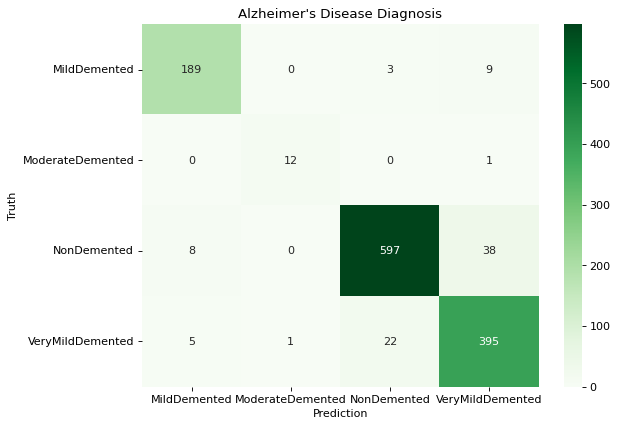

In [143]:
test_model(model, test_data)